<a href="https://colab.research.google.com/github/Yanlingwu95/Machine_Learning_Localization/blob/master/19_abs_std_Norm_Second_way_feature_new_data2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 授权绑定Google Drive 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

# 指定当前的工作目录
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Acoustic_Localization/keras/data") 


# 查看文件目录，是否包含所需的文件
!ls

19-Extraction-feature_abs_Con2D_Second_way.ipynb  data_19_1	hist.png   raw
3_20_data					  heat_map.png	processed


In [0]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras import backend as KK
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
from keras import regularizers
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers
from numpy import linalg as LA

In [0]:
# from numpy.random import seed
# seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)

In [90]:
#loading data
DDataFile = './3_20_data/qd_LOS_32_3GPPUMi_15k_SC5.mat'
#DDataFile = './data/latest/data/qd_LOS_32_3GPPUMi_15k_SC5.mat'
DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff_all = DData['h_coeff_real']
location = DData['positions']
#split the D_data and location_data and only need the first 2k
N = 15000
M = 32
h_coeff_real = np.array(h_coeff_all[:M,:N])
print(h_coeff_real[0])
h_coeff_img = np.array(h_coeff_all[M:,:N])
print(h_coeff_img[0])
h_coeff = h_coeff_real + 1j*h_coeff_img
print(h_coeff[0])

loc = np.transpose(location[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)

D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
DH = D.H
F = np.zeros([N, M * M], dtype = "complex_")

for i in range(N):
    h = np.asmatrix(h_coeff[:, i:i+1])
    v = (M **(1 / 6.0) / LA.norm(h, 2)) **(4/3.) * h
#     hH = h.H
    K = v * v.H
    B = D * K * DH
    F[i] =B.flatten().A
F = np.asarray(F)
print(F.shape)
print(type(F))

#Do normalization here for features !!! 
# Using std to normalize
# F = F - np.mean(F, axis = 0)
F = F / np.std(F, axis = 0)
print(F[0])


[ 2.85934693e-05 -2.08925441e-05 -3.02426759e-05 ...  1.18912265e-05
 -1.24083056e-05  1.00311257e-08]
[-2.09803789e-05 -2.79435966e-06  8.45817879e-06 ...  2.95269578e-05
  2.03121831e-05 -2.40373516e-05]
[ 2.85934693e-05-2.09803789e-05j -2.08925441e-05-2.79435966e-06j
 -3.02426759e-05+8.45817879e-06j ...  1.18912265e-05+2.95269578e-05j
 -1.24083056e-05+2.03121831e-05j  1.00311257e-08-2.40373516e-05j]
h_coeff shape (32, 15000)
loc shape (15000, 2)
(15000, 1024)
<class 'numpy.ndarray'>
[0.14954291-4.11170916e-17j 0.24650099-8.02115593e-02j
 0.16279235-4.64510436e-02j ... 0.66503139+1.15927378e-02j
 0.24208034+1.63978748e-02j 0.08656946-3.77523140e-17j]


In [91]:

# real_D = np.real(F)
# img_D = np.imag(F)

ft = np.absolute(F) # get the absolute of the F data

print("ft shape", ft.shape, type(ft))

print(F.shape,loc.shape)
total, l = F.shape
total, d = loc.shape

train_length = int(np.floor(total * 0.8))

impulses_train = ft[:train_length, :]
location_train = loc[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = ft[train_length:, :]
location_test = loc[train_length:,:]

 
print('impulses_train shape:', impulses_train.shape)
print('impulses_test shape:', impulses_test.shape)
print('location_train shape:', location_train.shape)
print('location_test shape:', location_test.shape)

ft shape (15000, 1024) <class 'numpy.ndarray'>
(15000, 1024) (15000, 2)
15000 12000 (12000, 1024) (12000, 2)
impulses_train shape: (12000, 1024)
impulses_test shape: (3000, 1024)
location_train shape: (12000, 2)
location_test shape: (3000, 2)


In [0]:
#Build the model
model = keras.Sequential()

model.add(keras.layers.normalization.BatchNormalization())

model.add(Dense(1024, activation = 'relu')) 
# model.add(Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l1(0.1)))   #the hidden layer number 

model.add(keras.layers.normalization.BatchNormalization())
model.add(Dense(512, activation = 'relu')) 

model.add(keras.layers.normalization.BatchNormalization())

model.add(Dense(512, activation = 'relu')) 
# model.add(Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l1(0.1)))   #the hidden layer number 

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [81]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr= 0.001) #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )

print(impulses_train.shape, location_train.shape)
print(type(impulses_train))

(12000, 1024) (12000, 2)
<class 'numpy.ndarray'>


In [87]:
#Train the model, iterating
print(impulses_train.shape, location_train.shape)
print(impulses_test.shape, location_test.shape)

history = model.fit(impulses_train, location_train,
                    batch_size = 100, # 50 -> 52138; 20->52088
                    epochs = 20,
                    verbose = 1,
                    validation_split = 0.1 #0.2
#                     validation_data=(impulses_test,location_test)
                   )


(12000, 1024) (12000, 2)
(3000, 1024) (3000, 2)
Train on 10800 samples, validate on 1200 samples
Epoch 1/20
10800/10800 [==============================] - 2s 140us/step - loss: 348.8199 - val_loss: 358.5243
Epoch 2/20
10800/10800 [==============================] - 1s 136us/step - loss: 345.1612 - val_loss: 322.4996
Epoch 3/20
10800/10800 [==============================] - 1s 138us/step - loss: 343.3852 - val_loss: 354.0358
Epoch 4/20
10800/10800 [==============================] - 1s 136us/step - loss: 329.1537 - val_loss: 332.6346
Epoch 5/20
10800/10800 [==============================] - 2s 140us/step - loss: 316.0360 - val_loss: 334.1857
Epoch 6/20
10800/10800 [==============================] - 1s 136us/step - loss: 300.5410 - val_loss: 365.1495
Epoch 7/20
10800/10800 [==============================] - 1s 137us/step - loss: 292.8010 - val_loss: 337.9033
Epoch 8/20
10800/10800 [==============================] - 1s 137us/step - loss: 286.7040 - val_loss: 330.9206
Epoch 9/20
10800/10800 

In [88]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

(3000, 2)
(3000, 2)
3000/3000 [==============================] - 0s 94us/step
Test loss & mean_absolute_error:  348.6538825683594


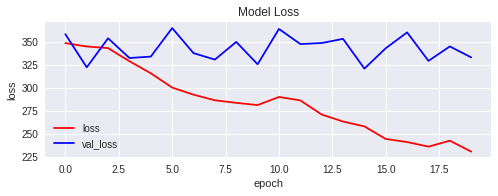

In [89]:
#plot the loss data
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()



# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.set_title('Location Scatter Plot')
# ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
# ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
# plt.legend()
# plt.show() 

error distance is  22.51537851413869
max error distance is  144.75791815328168
min error distance is  0.41767696387100706


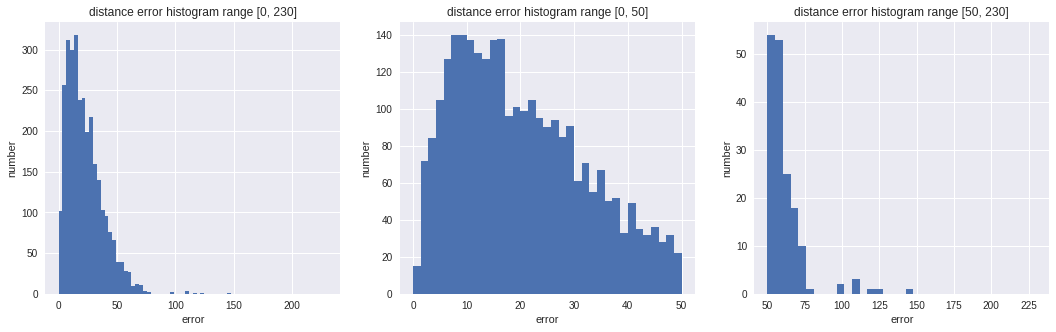

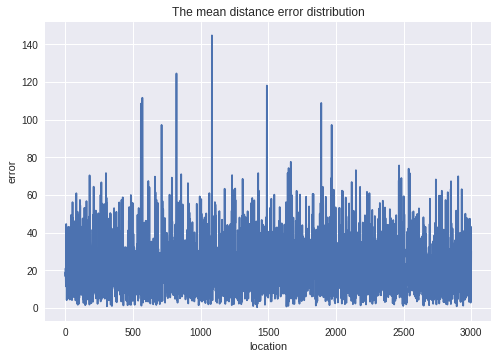

(3000, 1)

In [86]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist(err_dis, 70, range = [0, 230])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [0, 230]") 

plt.subplot(1,3,2)
plt.hist(err_dis, 35, range = [0, 50])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [0, 50]") 


plt.subplot(1,3,3)
plt.hist(err_dis, 35, range = [50,230])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [50, 230]") 
plt.savefig("hist.png")

plt.figure(3)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

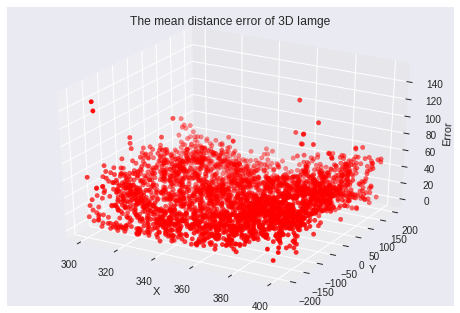

In [55]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

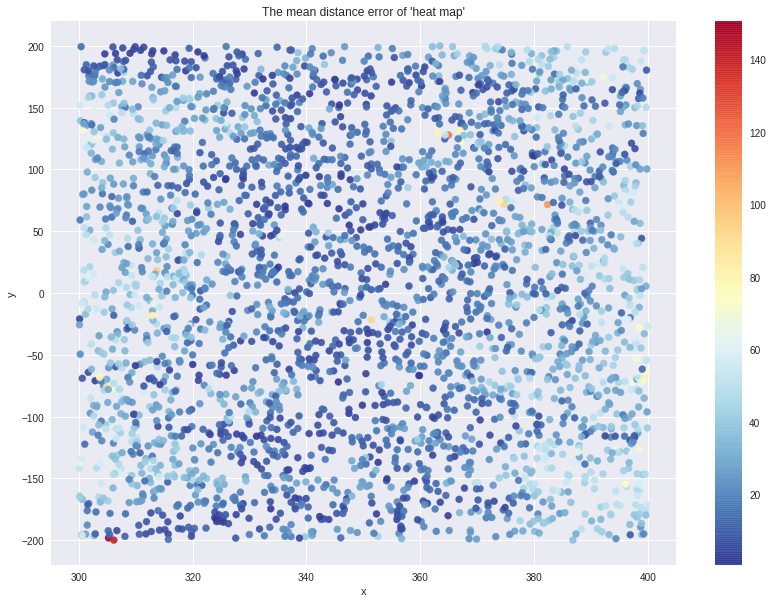

In [56]:
#draw the "heatmap" of error
fig = plt.figure(figsize=(14,10))
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.savefig("heat_map.png")

the mean of error nan
the max of error nan
the max of error nan


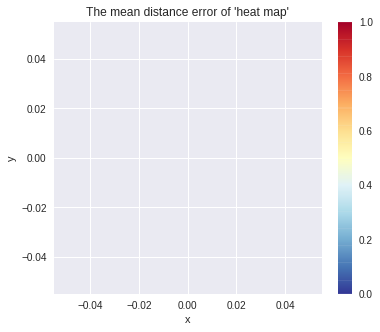

In [57]:
#plot small scale error map

err_map = np.hstack((location_test, err_dis))
err_map = pd.DataFrame(err_map, columns=['x', 'y', 'err'])
err_map_300 = err_map[err_map['x']<300]
err_map_300 = err_map_300[err_map_300['y']<150]
err_map_300 = err_map_300[err_map_300['y']>-150]
# np.array(err_map_300['x'])
print('the mean of error %f'% err_map_300['err'].mean())
print('the max of error %f'% err_map_300['err'].max())
print('the max of error %f'% err_map_300['err'].min())

fig = plt.figure(figsize=(6,5))
ax4 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r
sc = ax4.scatter(np.array(err_map_300['x']),np.array(err_map_300['y']),c = np.array(err_map_300['err']), marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.show()


Text(0.5, 1.0, 'distance error histogram')

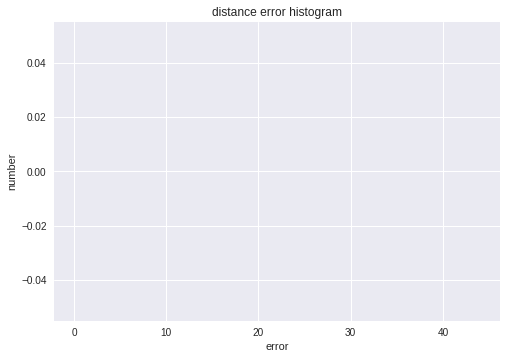

In [0]:

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(np.array(err_map_300['err']), bins =  range(0,45,1)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

## Conclusion :

number of layers| batch size | epoch | volidation | loss| error(average) | error(min)|
--|--|--|--|--|--|--|
3| 100| 100 | 0.1|1314.788985|22.5|0.23|
4| 100|100|0.1|1273.8396|24.5| 0.12|
batchnormalization 4| 100|100|0.1|overfitting|
batchnormalization 3| 100|100|0.1|82.426|8.4811|0.168|(BEST)
- three layers with mse batch size 100, epoch 100

In [0]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers
from numpy import linalg as LA

In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

#loading data
#DDataFile = './data/data_Emre/v_LOS_32_20k.mat'

DDataFile = './3_20_data/qd_LOS_32_3GPPUMi_15k_SC25.mat'

DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff_all = DData['h_coeff_real']
location = DData['positions']
#split the D_data and location_data and only need the first 2k
N = 15000
M = 32
h_coeff_real = np.array(h_coeff_all[:M,:N])
print(h_coeff_real[0])
h_coeff_img = np.array(h_coeff_all[M:,:N])
print(h_coeff_img[0])
h_coeff = h_coeff_real + 1j*h_coeff_img
print(h_coeff[0])


loc = np.transpose(location[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)

D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
DH = D.H
F = np.zeros([N, M, M], dtype = "complex_")

for i in range(N):
    h = np.asmatrix(h_coeff[:, i:i+1])
    v = (M **(1 / 6.0) / LA.norm(h, 2)) **(4/3.) * h
#     hH = h.H
    KK = v * v.H
    B = D * KK * DH
    F[i] = B.A
F = np.asarray(F)
print(F.shape)
print(type(F))


# Do normalization
F = F / np.std(F, axis = 0)

# real_D = np.real(F)
# img_D = np.imag(F)

ft = np.absolute(F) # get the absolute of the F data


print("ft shape", ft.shape, type(ft))

print(F.shape,loc.shape)
total, row, col = F.shape
total, d = loc.shape

train_length = int(np.floor(total * 0.8))

impulses_train = ft[:train_length, :]
location_train = loc[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = ft[train_length:, :]
location_test = loc[train_length:,:]

# input image dimensions
img_rows, img_cols = 32, 32

if K.image_data_format() == 'channels_first':
    impulses_train = impulses_train.reshape(impulses_train.shape[0], 1, img_rows, img_cols)
    impulses_test = impulses_test.reshape(impulses_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    impulses_train = impulses_train.reshape(impulses_train.shape[0], img_rows, img_cols, 1)
    impulses_test = impulses_test.reshape(impulses_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


print('impulses_train shape:', impulses_train.shape)
print('impulses_test shape:', impulses_test.shape)
print(impulses_train.shape[0], 'impulses_train samples')
print(impulses_test.shape[0], 'impulses_test samples')

[-1.82774576e-06 -3.86960471e-06  2.04233732e-05 ... -1.64511520e-05
  3.14835562e-05 -2.80238446e-05]
[-3.44423941e-05 -2.54798207e-05  9.84822041e-06 ...  2.80218005e-05
 -2.78844703e-05 -2.38926261e-07]
[-1.82774576e-06-3.44423941e-05j -3.86960471e-06-2.54798207e-05j
  2.04233732e-05+9.84822041e-06j ... -1.64511520e-05+2.80218005e-05j
  3.14835562e-05-2.78844703e-05j -2.80238446e-05-2.38926261e-07j]
h_coeff shape (32, 15000)
loc shape (15000, 2)
(15000, 32, 32)
<class 'numpy.ndarray'>
ft shape (15000, 32, 32) <class 'numpy.ndarray'>
(15000, 32, 32) (15000, 2)
15000 12000 (12000, 32, 32) (12000, 2)
impulses_train shape: (12000, 32, 32, 1)
impulses_test shape: (3000, 32, 32, 1)
12000 impulses_train samples
3000 impulses_test samples


(12000, 32, 32, 1) (12000, 2)
<class 'numpy.ndarray'>
(12000, 32, 32, 1) (12000, 2)
(3000, 32, 32, 1) (3000, 2)
Train on 9600 samples, validate on 2400 samples
Epoch 1/10
9600/9600 [==============================] - 9s 897us/step - loss: 5208.3423 - val_loss: 1403.4358
Epoch 2/10
9600/9600 [==============================] - 7s 746us/step - loss: 1325.2761 - val_loss: 1207.5070
Epoch 3/10
9600/9600 [==============================] - 7s 746us/step - loss: 1034.2403 - val_loss: 667.9383
Epoch 4/10
9600/9600 [==============================] - 7s 747us/step - loss: 900.5891 - val_loss: 858.0607
Epoch 5/10
9600/9600 [==============================] - 7s 751us/step - loss: 802.7445 - val_loss: 654.5230
Epoch 6/10
9600/9600 [==============================] - 7s 748us/step - loss: 766.3789 - val_loss: 628.6335
Epoch 7/10
9600/9600 [==============================] - 7s 747us/step - loss: 761.5015 - val_loss: 510.8763
Epoch 8/10
9600/9600 [==============================] - 7s 748us/step - loss: 7

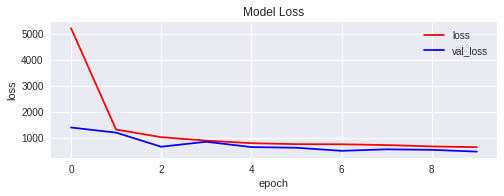

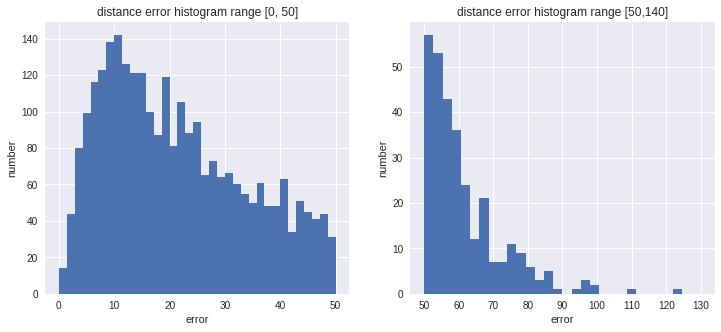

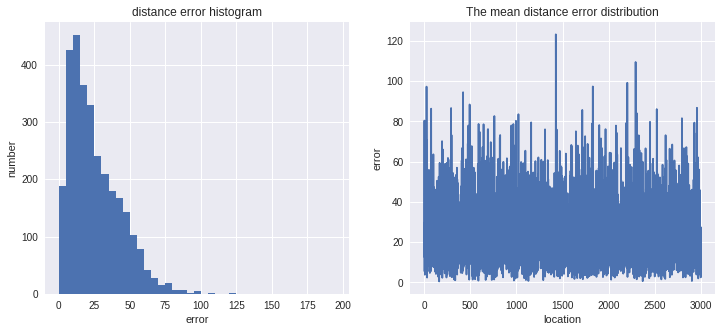

(3000, 1)

In [0]:
#Build the model
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(16, 16),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))

model.add(Dropout(0.4))
                 
model.add(keras.layers.Conv2D(32, kernel_size=(16, 16),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))

model.add(Dropout(0.4))
                 
model.add(keras.layers.Conv2D(32, kernel_size=(16, 16),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))
                               

model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))



model.add(Flatten())

model.add(keras.layers.normalization.BatchNormalization())

model.add(Dropout(0.4))

model.add(Dense(1024, activation = 'relu'))   #the hidden layer number 

model.add(Dense(1024, activation = 'relu'))   #the hidden layer number 

model.add(Dense(512, activation = 'relu')) 

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer


#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.001) #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )


print(impulses_train.shape, location_train.shape)
print(type(impulses_train))


#Train the model, iterating
print(impulses_train.shape, location_train.shape)
print(impulses_test.shape, location_test.shape)

history = model.fit(impulses_train, location_train,
                    batch_size = 50, # 50 -> 52138; 20->52088
                    epochs = 10,
                    verbose = 1,
                    validation_split = 0.2 #0.2
#                     validation_data=(impulses_test,location_test)
                   )


#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)


#plot the loss data
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()



#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(err_dis, 35, range = [0, 50])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [0, 50]") 

plt.subplot(1,2,2)
plt.hist(err_dis, 30, range = [50,130])
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram range [50,140]") 
plt.savefig("hist.png")

plt.figure(figsize=(12,5))
#plt.subplot(2,1,1)
plt.subplot(1,2,1)
plt.hist(err_dis, bins =  range(0,200,5)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.subplot(1,2,2)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape
